In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

import pickle

import warnings
warnings.filterwarnings('ignore')





In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv(r"/content/gdrive/MyDrive/database/training/train.csv")


# lets check the glimpse of first five rows of train dataset
print(df.head())



                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [ ]:
# shape of train dataframe
print(df.shape)

# Separate Independent and Dependent Variables
X = df['comment_text']
y = df.loc[:, 'toxic':].values


# lets check the comment maximum length 
print(df['comment_text'].str.len().max())




(159571, 8)
5000


In [ ]:
MAX_FEATURES = 200000 # number of words in the vocab




# Text Vectorization is the process of converting text into a numerical representation.
# It transforms text into a more suitable form so that ML or DL algorithms can perform better.
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, 
                               output_sequence_length=1800,  # Maximum comment (text) size in words
                               output_mode='int')



vectorizer.adapt(X.values)





# apply vectorizer on X
vectorized_text = vectorizer(X.values)

# prepare tensorflow dataset
# it converts the data stored in Pandas Data Frame into data stored in TensorFlow Data Set.
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
# cache keeps the images in memory after they're loaded off disk during the first epoch.
dataset = dataset.cache()
# For true randomness, we set the shuffle buffer to the full dataset size.
dataset = dataset.shuffle(160000)
# Batch after shuffling to get unique batches at each epoch
dataset = dataset.batch(16)
# prefetch overlaps data preprocessing and model execution while training.
dataset = dataset.prefetch(8) 






In [ ]:
# train(70%), validation(20%) and test(10%) split
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))





In [ ]:
# Formation of CNN model
# Sequential layer
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer/ output layer 
model.add(Dense(6, activation='sigmoid'))






In [ ]:
# Compile the Model
model.compile(loss='BinaryCrossentropy', optimizer='Adam')



# model summary
print(model.summary())


# fit model for only 9 epochs
history = model.fit(train, epochs=9, validation_data=val)
print(history)






Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

<Figure size 576x360 with 0 Axes>

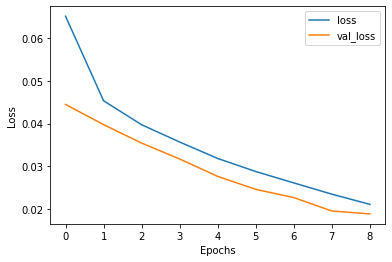

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# save the model for future use
model.save('toxic_comments_model.h5')


# save the model for future use
model.save('toxic_comments_model.h5')



In [ ]:
# load the model
model = tf.keras.models.load_model('toxic_comments_model.h5')

# use text vectorization on raw data to test the model
input_text = vectorizer(np.expand_dims('I am going to hit you.',0))

# model prediction on raw text
res = model.predict(input_text)
print(res)



# lets check the precision, recall and accuracy on test dataset 
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the true values
    y_true = y_true.flatten()
    # Flatten the predictions
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 2s 2s/step
[[3.0517212e-01 1.1604022e-04 2.9417221e-02 4.5216586e-02 6.3100159e-02
  5.1022548e-02]]
1/1 [==============================] - 0s 56ms/step
Precision: 0.9042493104934692, Recall:0.9042493104934692, Accuracy:0.5516549944877625


statement 1
1/1 [==============================] - 0s 54ms/step
toxic: True
severe_toxic: False
obscene: True
threat: False
insult: True
identity_hate: False

statement 2
1/1 [==============================] - 0s 51ms/step
toxic: True
severe_toxic: False
obscene: True
threat: False
insult: False
identity_hate: False

statement 3
1/1 [==============================] - 0s 52ms/step
toxic: True
severe_toxic: False
obscene: False
threat: False
insult: False
identity_hate: False

statement 4
1/1 [==============================] - 0s 53ms/step
toxic: False
severe_toxic: False
obscene: False
threat: False
insult: False
identity_hate: False



In [1]:
!pip install git+https://github.com/openai/whisper.git
!pip install transformers
!pip3 install imageio==2.4.1
!pip install moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-b_j66l7n
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-b_j66l7n
  Resolved https://github.com/openai/whisper.git to commit ad3250a846fe7553a25064a2dc593e492dadf040
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 KB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.8 MB/s eta 0:00:00
  Created wheel for ope

In [2]:
from moviepy.editor import *

import os
import math 
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import nltk
nltk.download('punkt')

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3227648/45929032 bytes (7.0%)5890048/45929032 bytes (12.8%)9166848/45929032 bytes (20.0%)11698176/45929032 bytes (25.5%)14516224/45929032 bytes (31.6%)17154048/45929032 bytes (37.3%)19537920/45929032 bytes (42.5%)22306816/45929032 bytes (48.6%)24846336/45929032 bytes (54.1%)27893760/45929032 bytes (60.7%)30498816/45929032 bytes (66.4%)33226752/45929032 bytes (72.3%)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
def run_range(duration):
  time=duration/30
  floor=math.ceil(time)
  return floor

time_range=30
clip_run_range=0
clip_duration=0

def audio_generator(path,aud=0,vid=0):
  global clip_run_range
  global clip_duration
  if vid==1:
    clip=VideoFileClip(path)
    clip_duration = clip.duration
    clip_run_range=run_range(clip_duration)
    for i in range(clip_run_range):
      left=i*time_range
      right=left+time_range
      # print(left,right)

      crop_clip=clip.subclip(left,right)
      try:
        crop_clip.audio.write_audiofile("vid_to_aud"+str(i)+".mp3")
      except:
        pass
  
  if aud==1:
    audio_clip=AudioFileClip(path)
    clip_duration = audio_clip.duration
    print(clip_duration)
    clip_run_range=run_range(clip_duration)
    print(clip_run_range)
    for i in range(clip_run_range):
      left=i*time_range
      right=left+time_range
      # print(left,right)
      crop_clip=audio_clip.subclip(left,right)
      try:
        crop_clip.write_audiofile("vid_to_aud"+str(i)+".mp3")
      except:
        pass

In [4]:
import whisper

model = whisper.load_model("large")

100%|██████████████████████████████████████| 2.87G/2.87G [00:12<00:00, 247MiB/s]


In [5]:
tokenizer = AutoTokenizer.from_pretrained("fabiochiu/t5-small-medium-title-generation")
title_model = AutoModelForSeq2SeqLM.from_pretrained("fabiochiu/t5-small-medium-title-generation")

In [ ]:
# load audio and pad/trim it to fit 30 seconds
def SpeechToText(path,title_flag=1):
  audio = whisper.load_audio(path)
  audio = whisper.pad_or_trim(audio)

  # make log-Mel spectrogram and move to the same device as the model
  mel = whisper.log_mel_spectrogram(audio).to(model.device)

  # detect the spoken language
  _, probs = model.detect_language(mel)
  # print(f"Detected language: {max(probs, key=probs.get)}")

  # decode the audio
  dectected_lang=max(probs, key=probs.get)
  # print(dectected_lang)
  # print(type(dectected_lang))
  if dectected_lang != "en":
    options = whisper.DecodingOptions(task="translate",language="en")
    # print(options)
    translated = whisper.decode(model, mel, options)

  options2 = whisper.DecodingOptions(task="transcribe")
  # print(options2)
  transcribed = whisper.decode(model, mel, options2)

  # print the recognized text
  
  if title_flag==1:
    if dectected_lang != "en":
      text=translated.text
    else:
      text=transcribed.text

    inputs = ["summarize: " + text]

    inputs = tokenizer(inputs,truncation=True, return_tensors="pt")
    output = title_model.generate(**inputs,num_beams=2, do_sample=True, min_length=5, max_length=10)
    decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
    predicted_title = nltk.sent_tokenize(decoded_output.strip())[0]
    return translated.text,transcribed.text,predicted_title
  return translated.text,transcribed.text

In [ ]:
audio_generator("../input/video-check/diabetes.mp4",vid=1)
transcribed_lit=[]
label_lit=[]
translated_lit=[]

In [ ]:
for i in tqdm(range(clip_run_range)):
    transcribed,label=SpeechToTextEng("./vid_to_aud"+str(i)+".mp3",1)
    transcribed_lit.append(transcribed)
    label_lit.append(label)
    os.remove("./vid_to_aud"+str(i)+".mp3")

In [ ]:
label_lit

In [ ]:
def SpeechToTextEng(path,title_flag=1):
  audio = whisper.load_audio(path)
  audio = whisper.pad_or_trim(audio)

  # make log-Mel spectrogram and move to the same device as the model
  mel = whisper.log_mel_spectrogram(audio).to(model.device)

  # detect the spoken language
  _, probs = model.detect_language(mel)
  # print(f"Detected language: {max(probs, key=probs.get)}")

  # decode the audio
  dectected_lang=max(probs, key=probs.get)
  # print(dectected_lang)
  # print(type(dectected_lang))
  # if dectected_lang != "en":
  #   options = whisper.DecodingOptions(task="translate",language="en")
  #   # print(options)
  #   translated = whisper.decode(model, mel, options)

  options2 = whisper.DecodingOptions(task="transcribe")
  # print(options2)
  transcribed = whisper.decode(model, mel, options2)
  # print(transcribed.text)
  # print the recognized text
  
  if title_flag==1:
    
    # if dectected_lang != "en":
    #   text=translated.text
    # else:
    #   text=transcribed.text
    text=transcribed.text
#     predicted_title=summarizer(text,max_length=10, min_length=0, do_sample=False)[0].get("summary_text")
    # old attempt
    inputs = ["summarize: " + text]

    inputs = tokenizer(inputs,truncation=True, return_tensors="pt")
    output = title_model.generate(**inputs, num_beams=2, do_sample=True, min_length=5, max_length=10)

    decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
    predicted_title = nltk.sent_tokenize(decoded_output.strip())[0]

    return transcribed.text,predicted_title
    
  return transcribed.text

In [ ]:
audio_generator("../input/magic-of-maths/magic.m4a",aud=1)
transcribed_lit=[]
label_lit=[]
for i in range(clip_run_range):
    transcribed,label=SpeechToTextEng("./vid_to_aud"+str(i)+".mp3",1)
    transcribed_lit.append(transcribed)
    label_lit.append(label)
    os.remove("./vid_to_aud"+str(i)+".mp3")

In [ ]:
print("transcribed - ",transcribed_lit)
print("label - ",label_lit)

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

print(score_comment(transcribed_lit))



# save the labels for further use in deployment
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
pickle.dump(labels,open('labels.pkl','wb'))